COD PENTRU VIZUALIZAREA PROCESULUI DE ALINIERE SI REDIMENSIONARE A IMAGINILOR OARECARE INAINTE DE PROCESARE 

In [ ]:
import os
import sys
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import ops
from keras import layers


from PIL import Image
import matplotlib.pyplot as plt

from keras import utils, models
from keras.layers import Rescaling
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input


print('keras: ', keras.__version__)
print('tensorflow: ',tf.__version__)
print('python: ',sys.version)
print(tf.version.GIT_VERSION, tf.version.VERSION)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#####CONFIGS#####
Train = True
epochs = 100
latent_dim = 512
BATCH_SIZE_PER_REPLICA = 64
###################


strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a face."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(280602)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon
    
def create_encoder(input_shape=(128, 128, 3), latent_dim=512):
    inputs = keras.Input(shape=input_shape)
    
    
    x = layers.Conv2D(64, (4,4), activation='leaky_relu', strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(128, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(256, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(512, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Flatten()(x)
    
    # Add dense layers before final latent space
    x = layers.Dense(512, activation='leaky_relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    
    return keras.Model(inputs, [z_mean, z_log_var, z], name='improved_encoder')


def create_decoder(latent_dim=512):
    latent_inputs = keras.Input(shape=(latent_dim,))
    
    x = layers.Dense(8*8*512, activation='leaky_relu')(latent_inputs)
    x = layers.Reshape((8, 8, 512))(x)
    
    x = layers.Conv2DTranspose(256, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(128, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(64, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(32, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    decoder_outputs = layers.Conv2DTranspose(3, (4,4), activation='sigmoid', padding='same')(x)
    
    return keras.Model(latent_inputs, decoder_outputs, name='improved_decoder')


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.lambda_reconstruction = 0.1
        self.lambda_perceptual = 0.1
        
        # Initialize VGG19 for feature extraction (use pre-trained weights)
        vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None, None, 3))
        
        # Choose intermediate layers for feature comparison
        self.feature_layers = [
            'block1_conv2',  # Low-level features
            'block2_conv2',  # Mid-level features
            'block3_conv2',  # Higher-level features
            'block4_conv2'   # Very high-level features
        ]
        
        # Create a model that outputs features from these layers
        self.feature_extractor = keras.Model(
            inputs=vgg.input, 
            outputs=[vgg.get_layer(name).output for name in self.feature_layers]
        )
        
        # Freeze the VGG19 weights
        self.feature_extractor.trainable = False
        
        # Tracking metrics
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.perceptual_loss_tracker = keras.metrics.Mean(name='perceptual_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')
        
        # Add validation metrics
        self.val_total_loss_tracker = keras.metrics.Mean(name='val_total_loss')
        self.val_reconstruction_loss_tracker = keras.metrics.Mean(name='val_reconstruction_loss')
        self.val_perceptual_loss_tracker = keras.metrics.Mean(name='val_perceptual_loss')
        self.val_kl_loss_tracker = keras.metrics.Mean(name='val_kl_loss')
    
    def call(self, inputs):
        # Implement the forward pass
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction
    
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.perceptual_loss_tracker,
            self.kl_loss_tracker,
            self.val_total_loss_tracker,
            self.val_reconstruction_loss_tracker,
            self.val_perceptual_loss_tracker,
            self.val_kl_loss_tracker
        ]
    
    def compute_perceptual_loss(self, original, reconstructed):
        # Preprocess images for VGG19 (ensure 3 channels and correct scaling)
        original_processed = preprocess_input(original * 255.0)
        reconstructed_processed = preprocess_input(reconstructed * 255.0)
        
        # Extract features for original and reconstructed images
        original_features = self.feature_extractor(original_processed)
        reconstructed_features = self.feature_extractor(reconstructed_processed)
    
        
        # Compute perceptual loss as mean squared error between features
        perceptual_loss = 0
        for orig_feat, recon_feat in zip(original_features, reconstructed_features):
            perceptual_loss += ops.mean(ops.square(orig_feat - recon_feat))

        
        # Normalize by the number of feature layers
        perceptual_loss /= len(self.feature_layers)
        
        return perceptual_loss
    
    def compute_reconstruction_loss(self, original, reconstructed):
        
        reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(original, reconstructed),
                    axis=(1,2)
                )
            )
        
        return reconstruction_loss
   
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Encoder forward pass
            z_mean, z_log_var, z = self.encoder(data)
            
            # Decoder reconstruction
            reconstruction = self.decoder(z)
            
            # Compute KL divergence loss
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            
            
            # Compute perceptual loss using VGG19 features
            perceptual_loss = self.compute_perceptual_loss(data, reconstruction) * self.lambda_perceptual
            
            reconstruction_loss = self.compute_reconstruction_loss(data, reconstruction) * self.lambda_reconstruction
            
            # Total loss combines reconstruction losses and KL divergence
            total_loss = kl_loss + (perceptual_loss + reconstruction_loss)/2
        
        # Compute gradients and apply them
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.perceptual_loss_tracker.update_state(perceptual_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "perceptual_loss": self.perceptual_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result()
        }
    
    def test_step(self, data):
        # Encoder forward pass
        z_mean, z_log_var, z = self.encoder(data)
        
        # Decoder reconstruction
        reconstruction = self.decoder(z)
        
        # Compute KL divergence loss
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        
        # Compute perceptual loss using VGG19 features
        perceptual_loss = self.compute_perceptual_loss(data, reconstruction) * self.lambda_perceptual
        
        reconstruction_loss = self.compute_reconstruction_loss(data, reconstruction) * self.lambda_reconstruction
        
        # Total loss combines perceptual loss and KL divergence
        total_loss = kl_loss + (reconstruction_loss + perceptual_loss)/2
        
        # Update validation metrics
        self.val_total_loss_tracker.update_state(total_loss)
        self.val_perceptual_loss_tracker.update_state(perceptual_loss)
        self.val_kl_loss_tracker.update_state(kl_loss)
        self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        return {
            "loss": self.val_total_loss_tracker.result(),
            "perceptual_loss": self.val_perceptual_loss_tracker.result(),
            "kl_loss": self.val_kl_loss_tracker.result(),
            "reconstruction_loss": self.val_reconstruction_loss_tracker.result()
        }

encoder = create_encoder(latent_dim=512)
decoder = create_decoder(latent_dim=512)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))
vae.load_weights('results_encode_decode/20/vae_weights.weights.h5')
vae.summary()

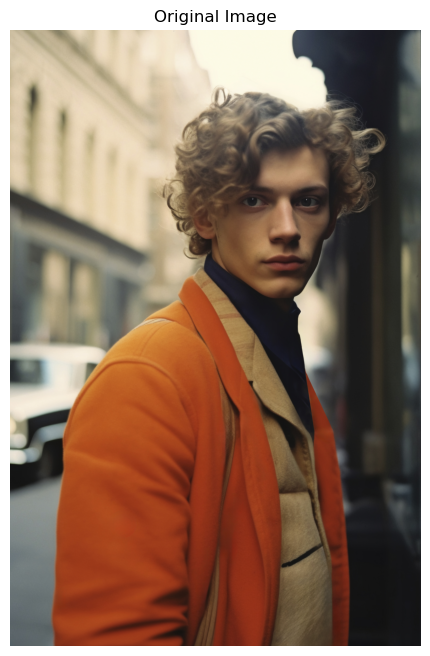

In [2]:

# Load and display the test image
image_path = 'test_align_2.jpg'
test_image = Image.open(image_path)

# Display the original image
plt.figure(figsize=(8, 8))
plt.imshow(test_image)
plt.title('Original Image')
plt.axis('off')
plt.show()


/tmp/ipykernel_3885064/4139917663.py:33: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, skiprows=2, names=["image"] + columns)


{'left_eye': [69.35386650477051, 111.19798222103762],
 'right_eye': [107.64403081950059, 111.16160000789738],
 'nose': [88.0631395021693, 135.10202419557845],
 'left_mouth': [71.24745926682758, 152.11301141664075],
 'right_mouth': [105.5864293505891, 152.19466038825462]}

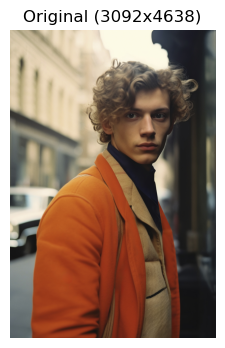

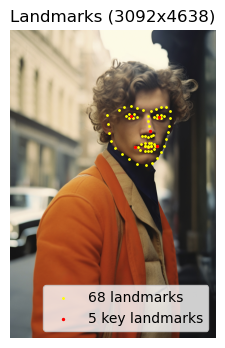

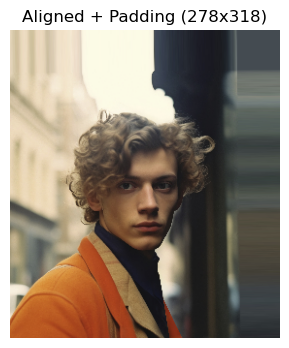

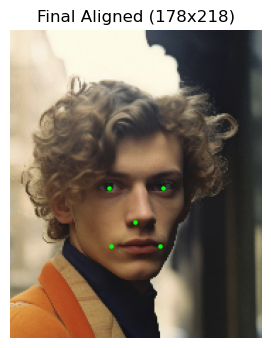

In [4]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import dlib
import pandas as pd
from collections import OrderedDict
import os

def get_landmark_points(shape, facial_landmarks_dict):
    points = {}
    for (name, (start, end)) in facial_landmarks_dict.items():
        if start == end:
            points[name] = (shape.part(start).x, shape.part(start).y)
        else:
            x_sum = 0
            y_sum = 0
            for i in range(start, end + 1):
                x_sum += shape.part(i).x
                y_sum += shape.part(i).y
            points[name] = (x_sum // (end - start + 1), y_sum // (end - start + 1))
    return points

# --- Compute mean landmarks from CelebA ---
def compute_mean_celeba_landmarks(file_path):
    columns = [
        "lefteye_x", "lefteye_y",
        "righteye_x", "righteye_y",
        "nose_x", "nose_y",
        "leftmouth_x", "leftmouth_y",
        "rightmouth_x", "rightmouth_y"
    ]
    df = pd.read_csv(file_path, delim_whitespace=True, skiprows=2, names=["image"] + columns)
    mean_landmarks = {
        "left_eye": [df["lefteye_x"].mean(), df["lefteye_y"].mean()],
        "right_eye": [df["righteye_x"].mean(), df["righteye_y"].mean()],
        "nose": [df["nose_x"].mean(), df["nose_y"].mean()],
        "left_mouth": [df["leftmouth_x"].mean(), df["leftmouth_y"].mean()],
        "right_mouth": [df["rightmouth_x"].mean(), df["rightmouth_y"].mean()],
    }
    return mean_landmarks

file_path = "Dataset/list_landmarks_align_celeba.txt"
save_dir = "results_encode_decode/20/attribute_analysis/analysis"
os.makedirs(save_dir, exist_ok=True)
means = compute_mean_celeba_landmarks(file_path)
display(means)
mean_landmarks_np = np.array([
    means["left_eye"],
    means["right_eye"],
    means["nose"],
    means["left_mouth"],
    means["right_mouth"]
], dtype=np.float32)

# --- Dlib landmark helpers ---
from collections import OrderedDict
def get_landmark_points(shape, facial_landmarks_dict):
    points = {}
    for (name, (start, end)) in facial_landmarks_dict.items():
        if start == end:
            points[name] = (shape.part(start).x, shape.part(start).y)
        else:
            x_sum = 0
            y_sum = 0
            for i in range(start, end + 1):
                x_sum += shape.part(i).x
                y_sum += shape.part(i).y
            points[name] = (x_sum // (end - start + 1), y_sum // (end - start + 1))
    return points

FACIAL_LANDMARKS = OrderedDict([
    ("left_eye", (36, 41)),       
    ("right_eye", (42, 47)),     
    ("nose", (30, 30)),           
    ("left_mouth", (48, 48)),     
    ("right_mouth", (54, 54))     
])

# --- Main visualisation pipeline ---
image_path = 'test_align_2.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
output_size = (178, 218)

# 1. Show original image
plt.figure(figsize=(4, 4))
plt.imshow(image_rgb)
h, w = image_rgb.shape[:2]
plt.title(f'Original ({w}x{h})')
plt.axis('off')
plt.savefig(os.path.join(save_dir, "ARP_original.png"), bbox_inches='tight')
plt.show()

#Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faces = detector(gray, 1)
face = faces[0]
shape = predictor(gray, face)
landmarks = get_landmark_points(shape, FACIAL_LANDMARKS)

#All 68 landmarks (yellow) and 5 key landmarks (red) on the same plot
plt.figure(figsize=(4, 4))
plt.imshow(image_rgb)
x68 = [shape.part(i).x for i in range(68)]
y68 = [shape.part(i).y for i in range(68)]
plt.scatter(x68, y68, c='yellow', s=1, label='68 landmarks')
x5 = [point[0] for point in landmarks.values()]
y5 = [point[1] for point in landmarks.values()]
plt.scatter(x5, y5, c='red', s=2, label='5 key landmarks')
plt.title(f'Landmarks ({w}x{h})')
plt.axis('off')
plt.legend(loc='lower right')
plt.savefig(os.path.join(save_dir, "ARP_landmarks.png"), bbox_inches='tight')
plt.show()

src_points = np.array([
    landmarks["left_eye"],
    landmarks["right_eye"],
    landmarks["nose"],
    landmarks["left_mouth"],
    landmarks["right_mouth"]
], dtype=np.float32)

dst_points = mean_landmarks_np

M = cv2.estimateAffinePartial2D(src_points, dst_points)[0]

padding = 50
padded_size = (output_size[0] + 2*padding, output_size[1] + 2*padding)

M[0, 2] += padding
M[1, 2] += padding

aligned_face_padded = cv2.warpAffine(
    image, 
    M, 
    padded_size,
    flags=cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_REPLICATE
)

#Show aligned face with padding and mean landmarks
plt.figure(figsize=(4, 4))
aligned_h, aligned_w = aligned_face_padded.shape[:2]
plt.imshow(cv2.cvtColor(aligned_face_padded, cv2.COLOR_BGR2RGB))
plt.title(f'Aligned + Padding ({aligned_w}x{aligned_h})')
plt.axis('off')
plt.savefig(os.path.join(save_dir, "ARP_aligned_padded.png"), bbox_inches='tight')
plt.show()

start_x = padding
start_y = padding
aligned_face = aligned_face_padded[start_y:start_y + output_size[1], 
                                   start_x:start_x + output_size[0]]

mask = np.all(aligned_face == [0, 0, 0], axis=2).astype(np.uint8) * 255

if np.any(mask):
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)
    aligned_face = cv2.inpaint(aligned_face, mask, 3, cv2.INPAINT_TELEA)

#Final aligned face 
plt.figure(figsize=(4, 4))
final_h, final_w = aligned_face.shape[:2]
plt.imshow(cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB))
plt.scatter(mean_landmarks_np[:,0], mean_landmarks_np[:,1], c='lime', s=5)
plt.title(f'Final Aligned ({final_w}x{final_h})')
plt.axis('off')
plt.savefig(os.path.join(save_dir, "ARP_final_crop.png"), bbox_inches='tight')
plt.show()